In [1]:
import fitparse 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fitfile = fitparse.FitFile('Diablerets.fit')

data_points = []

for record in fitfile.get_messages('record'):
    record_data = {}
    for record_data_entry in record:
        record_data[record_data_entry.name] = record_data_entry.value
    data_points.append(record_data)

In [3]:
df = pd.DataFrame(data_points)

# Latitude and Longitude conversion
conversion_factor = 180 / (2**31)
df['latitude'] = df['position_lat'] * conversion_factor
df['longitude'] = df['position_long'] * conversion_factor
df.drop(['position_lat', 'position_long'], axis=1, inplace=True)

# Timestamp conversion into datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Data cleaning of "NAN" fields 
print("Missing values before cleaning :")
print(df.isna().sum())

cols_to_fix = ['heart_rate', 'enhanced_speed', 'accumulated_power', 'power', 'enhanced_altitude', 'step_length', 'cadence','latitude', 'longitude']

for col in cols_to_fix:
    df[col] = df[col].interpolate(method='linear').ffill().bfill()

print('\n','-'*30)
print('\n', df.isna().sum())
print('data is now clean !')
df.describe()

Missing values before cleaning :
activity_type               0
cadence                     0
distance                    0
enhanced_altitude           0
enhanced_speed              0
fractional_cadence          0
heart_rate                  0
power                       0
stance_time              6435
stance_time_balance     12685
stance_time_percent     12685
step_length              5267
vertical_oscillation     4392
vertical_ratio           5267
unknown_107                 0
unknown_134             12685
unknown_135                 0
unknown_136                 0
unknown_137                 0
unknown_138                 0
unknown_140                 0
unknown_143                 0
unknown_144                 0
unknown_87                  4
accumulated_power           3
unknown_90                360
latitude                    0
longitude                   0
dtype: int64

 ------------------------------

 activity_type               0
cadence                     0
distance           

,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,power,stance_time,step_length,vertical_oscillation,...,unknown_137,unknown_138,unknown_140,unknown_143,unknown_144,unknown_87,accumulated_power,unknown_90,latitude,longitude
count,12685.000000,12685.000000,12685.000000,12685.000000,12685.000000,12685.000000,12685.000000,6250.000000,12685.000000,8293.000000,...,12685.000000,12685.000000,12685.000000,12685.000000,12685.000000,12681.000000,1.268500e+04,12325.000000,12685.000000,12685.000000
mean,49.131573,12166.753143,1761.664580,1.962606,0.205321,159.113126,184.862751,286.828000,897.309302,79.581382,...,63.541348,63.466456,2502.864407,37.583130,159.113126,707.095103,1.373434e+06,-2.288195,46.363304,7.182018
std,37.456902,6356.134382,338.041071,1.000453,0.245985,6.167397,162.550483,42.487087,255.263608,14.856261,...,13.746980,13.773443,977.220981,9.624803,6.167397,6069.981793,6.147183e+05,0.742830,0.011460,0.015975
min,0.000000,1.960000,1157.600000,0.000000,0.000000,125.000000,0.000000,193.000000,351.000000,39.300000,...,40.000000,40.000000,0.000000,24.000000,125.000000,0.000000,2.060000e+02,-3.000000,46.338764,7.153697
25%,0.000000,6818.820000,1453.000000,1.204000,0.000000,156.000000,0.000000,267.000000,714.353167,65.900000,...,52.000000,51.000000,2073.000000,29.000000,156.000000,0.000000,9.034960e+05,-3.000000,46.353617,7.167598
50%,62.000000,11938.320000,1793.800000,2.015000,0.000000,160.000000,208.000000,281.000000,846.454545,83.800000,...,63.000000,63.000000,2651.000000,36.000000,160.000000,0.000000,1.491519e+06,-2.000000,46.364441,7.184018
75%,83.000000,16911.850000,2064.200000,2.678000,0.500000,164.000000,321.000000,295.000000,1021.000000,90.500000,...,74.000000,74.000000,3141.000000,45.000000,164.000000,0.000000,1.836673e+06,-2.000000,46.374803,7.197147
max,125.000000,24948.730000,2254.000000,4.591000,0.500000,171.000000,868.000000,467.000000,1980.000000,125.800000,...,94.000000,94.000000,6687.000000,57.000000,171.000000,65534.000000,2.344983e+06,-1.000000,46.380428,7.211541


⚠️ Detected cadence in RPM (Cycles). Converting to SPM (x2)...


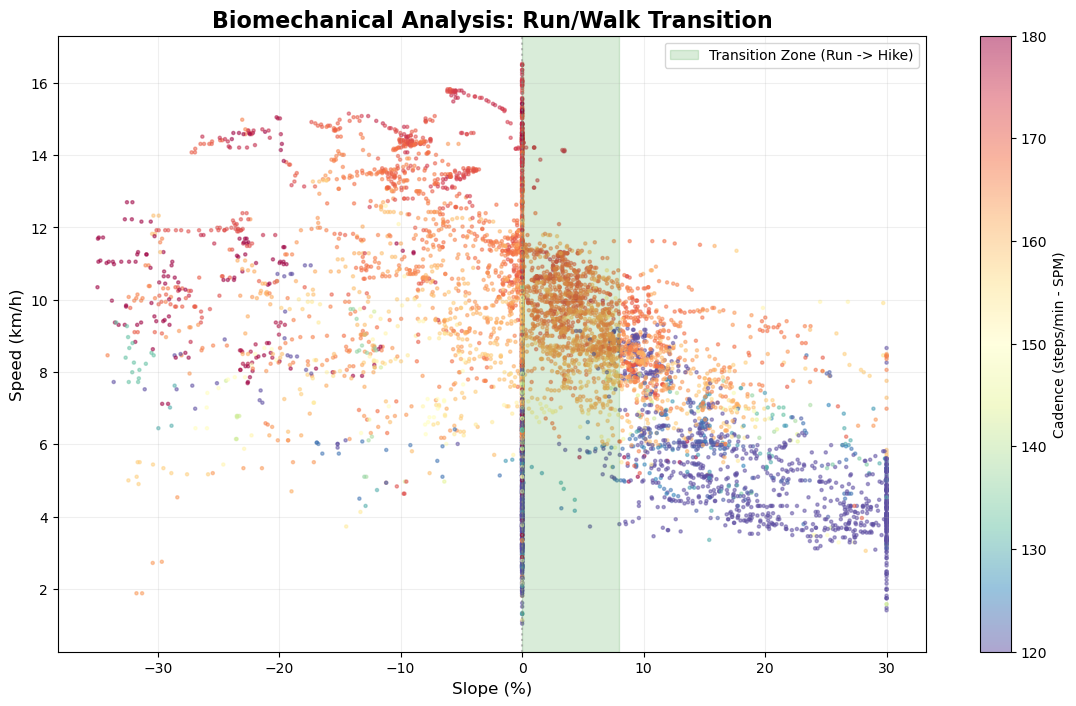

Corrected Max Cadence: 250 spm
Corrected Average Cadence: 150 spm


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DATA CLEANING & FEATURE ENGINEERING ---
df_graph = df.copy()

# Calculate speed in km/h
df_graph['speed_kmh'] = df_graph['enhanced_speed'] * 3.6

df['delta_alt'] = df['enhanced_altitude'].diff()
df['delta_dist'] = df['distance'].diff()

df['delta_dist'] = df['delta_dist'].replace(0, np.nan)

df['slope_raw'] = (df['delta_alt'] / df['delta_dist']) * 100

df['slope_smooth'] = df['slope_raw'].rolling(window=25, center=True).mean()
df['slope_smooth'] = df['slope_smooth'].clip(-50, 30)
df['slope_smooth'] = df['slope_smooth'].fillna(0)


def calculate_energy_cost(slope_percent):
    # La pente doit être en fraction (ex: 10% -> 0.1)
    g = slope_percent / 100
    
    # Formule simplifiée du coût énergétique relative au plat (1.0 = plat)
    # C'est une courbe polynomiale qui augmente fort en montée
    cost = 155.4 * g**5 - 30.4 * g**4 - 43.3 * g**3 + 46.3 * g**2 + 19.5 * g + 3.6
    
    # Sur le plat, le coût est d'environ 3.6 J/kg/m. On normalise.
    return cost / 3.6

df['energy_cost'] = df['slope_smooth'].apply(calculate_energy_cost)

df['gap_speed'] = df['enhanced_speed'] * df['energy_cost']

# Check if cadence is in "Cycles" (RPM) or "Steps" (SPM)
if df_graph['cadence'].median() < 100:
    print("⚠️ Detected cadence in RPM (Cycles). Converting to SPM (x2)...")
    df_graph['cadence'] = df_graph['cadence'] * 2
else:
    print("✅ Cadence already in SPM.")

# FILTERS: Keep a realistic range for a trail run
df_graph = df_graph[
 (df_graph['speed_kmh'] > 1) &  
    (df_graph['slope_smooth'] > -35) &  
    (df_graph['slope_smooth'] < 35) &
    (df_graph['speed_kmh'] < 25) &
    (df_graph['cadence'] > 30)
]

# --- 2. OPTIMIZED VISUALIZATION ---

plt.figure(figsize=(14, 8))

# Scatter Plot
points = plt.scatter(
    x=df_graph['slope_smooth'],
    y=df_graph['speed_kmh'],
    c=df_graph['cadence'], # Color is determined by cadence
    cmap='Spectral_r',     # Palette: Red (High) -> Blue (Low)
    s=5,                   # Point size
    alpha=0.5,             # Transparency
    vmin=120,              # Below 120 spm is fully blue (Walking)
    vmax=180               # Above 180 spm is fully red (Intense Running)
)


# Run/Walk transition zone
plt.axvspan(0, 8, color='green', alpha=0.15, label='Transition Zone (Run -> Hike)')

# --- 3. AESTHETICS ---
plt.colorbar(points, label='Cadence (steps/min - SPM)')
plt.title("Biomechanical Analysis: Run/Walk Transition", fontsize=16, fontweight='bold')
plt.xlabel("Slope (%)", fontsize=12)
plt.ylabel("Speed (km/h)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend(loc='upper right')

plt.axvline(0, color='gray', linestyle=':', alpha=0.5)

plt.show()

print(f"Corrected Max Cadence: {df_graph['cadence'].max()} spm")
print(f"Corrected Average Cadence: {df_graph['cadence'].mean():.0f} spm")

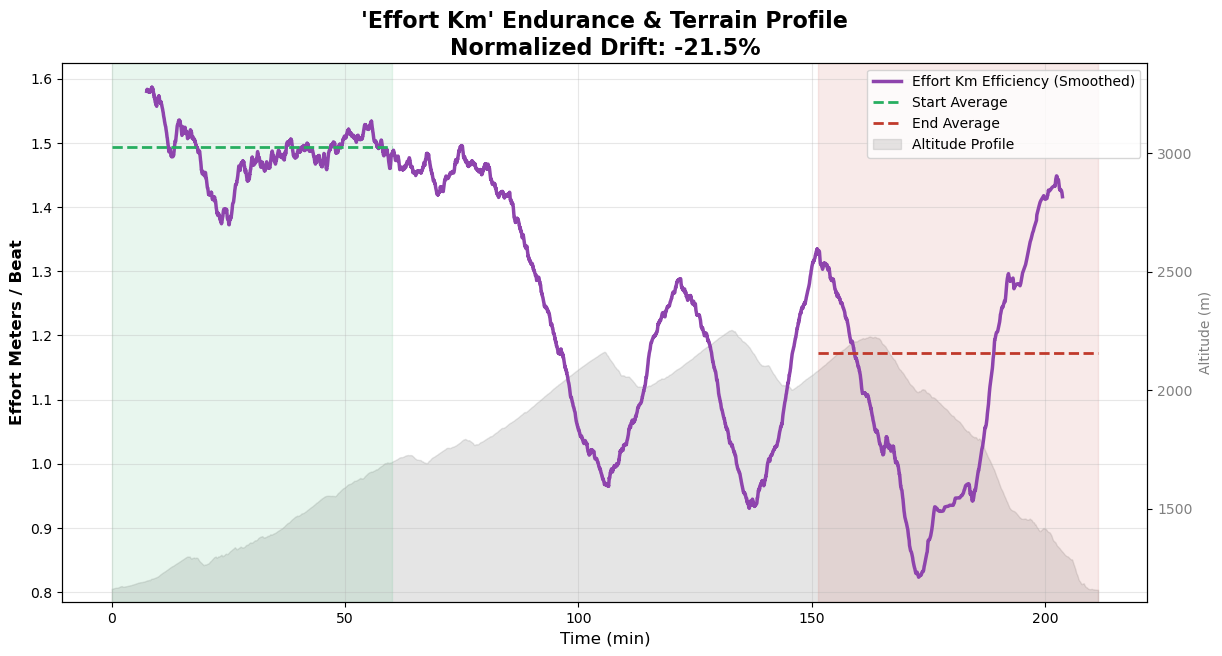

--- EFFORT KM ANALYSIS ---
Start: 1.49 effort-meters / beat
End: 1.17 effort-meters / beat
Drift: -21.46%


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. "EFFORT KILOMETER" CALCULATION ---
df_eff = df.copy()

# Calculate Elevation Gain (D+) and Effort Speed
df_eff['delta_alt'] = df_eff['enhanced_altitude'].diff()
df_eff['gain_pos'] = df_eff['delta_alt'].clip(lower=0)

# Speed in m/min
real_speed_m_min = df_eff['enhanced_speed'] * 60
# Effort bonus: Assuming 1m elevation gain = 10m flat distance
effort_bonus_m_min = (df_eff['gain_pos'] * 10) * 60
df_eff['effort_speed_m_min'] = real_speed_m_min + effort_bonus_m_min

# --- 2. EFFICIENCY RATIO CALCULATION ---

# Filters: Only consider active segments
mask_active = (df_eff['heart_rate'] > 40) & (df_eff['effort_speed_m_min'] > 50)
df_eff = df_eff[mask_active]

# Key Metric: Meters of Effort per Heart Beat
df_eff['efficiency_effort'] = df_eff['effort_speed_m_min'] / df_eff['heart_rate']

# Smoothing (900s = 15 min for a long-term trend)
df_eff['time_min'] = (df_eff.index - df_eff.index[0]).total_seconds() / 60
df_eff['ef_smooth'] = df_eff['efficiency_effort'].rolling(window=900, center=True).mean()

# --- 3. COMPARISON: FIRST HOUR vs LAST HOUR ---
total_time = df_eff['time_min'].max()
mask_first = (df_eff['time_min'] <= 60)
mask_last = (df_eff['time_min'] >= (total_time - 60))

# Mean efficiency for the first and last hour
avg_first = df_eff.loc[mask_first, 'efficiency_effort'].mean()
avg_last = df_eff.loc[mask_last, 'efficiency_effort'].mean()

# Percentage loss/drift
loss_pct = (avg_first - avg_last) / avg_first * 100

# --- 4. VISUALIZATION WITH TERRAIN (DUAL AXIS) ---

fig, ax1 = plt.subplots(figsize=(14, 7))
# --- BACKGROUND: TERRAIN PROFILE (Right Axis) ---
ax2 = ax1.twinx() # Create a twin axis sharing the same X-axis

# Plot the filled area for altitude
ax2.fill_between(
    df_eff['time_min'], 
    df_eff['enhanced_altitude'], 
    color='gray', 
    alpha=0.2, # Transparency
    label='Altitude Profile'
)

# Altitude Axis Aesthetics
ax2.set_ylabel('Altitude (m)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False) # Remove grid for altitude, keep the efficiency grid

# Adjust altitude scale to keep the curve low (visual trick)
alt_min = df_eff['enhanced_altitude'].min()
alt_max = df_eff['enhanced_altitude'].max()
# Force the y-axis to extend significantly upwards, compressing the altitude profile visually
ax2.set_ylim(alt_min - 50, alt_max * 1.5)

# --- FOREGROUND: EFFICIENCY (Left Axis) ---
sns.lineplot(
    data=df_eff,
    x='time_min',
    y='ef_smooth',
    color='#8e44ad',
    linewidth=2.5,
    label='Effort Km Efficiency (Smoothed)',
    ax=ax1 # Plot on the primary axis
)

# Mean Lines (On ax1)
ax1.hlines(avg_first, 0, 60, color='#27ae60', linestyle='--', linewidth=2, label='Start Average')
ax1.hlines(avg_last, total_time - 60, total_time, color='#c0392b', linestyle='--', linewidth=2, label='End Average')

# Highlighted Zones (On ax1)
ax1.axvspan(0, 60, color='#27ae60', alpha=0.1)
ax1.axvspan(total_time - 60, total_time, color='#c0392b', alpha=0.1)

# --- GENERAL AESTHETICS ---
# Ensure the efficiency line is above the altitude background (Z-Order)
ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False) # Make the background of axis 1 transparent
plt.title(f"'Effort Km' Endurance & Terrain Profile\nNormalized Drift: -{loss_pct:.1f}%", fontsize=16, fontweight='bold')
ax1.set_xlabel("Time (min)", fontsize=12)
ax1.set_ylabel("Effort Meters / Beat", fontsize=12, fontweight='bold')

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

ax1.grid(True, alpha=0.3)

plt.show()

print(f"--- EFFORT KM ANALYSIS ---")
print(f"Start: {avg_first:.2f} effort-meters / beat")
print(f"End: {avg_last:.2f} effort-meters / beat")
print(f"Drift: -{loss_pct:.2f}%")

🔥 TARGET: HR Peak (171 bpm) reached at 2025-09-27 11:38:52


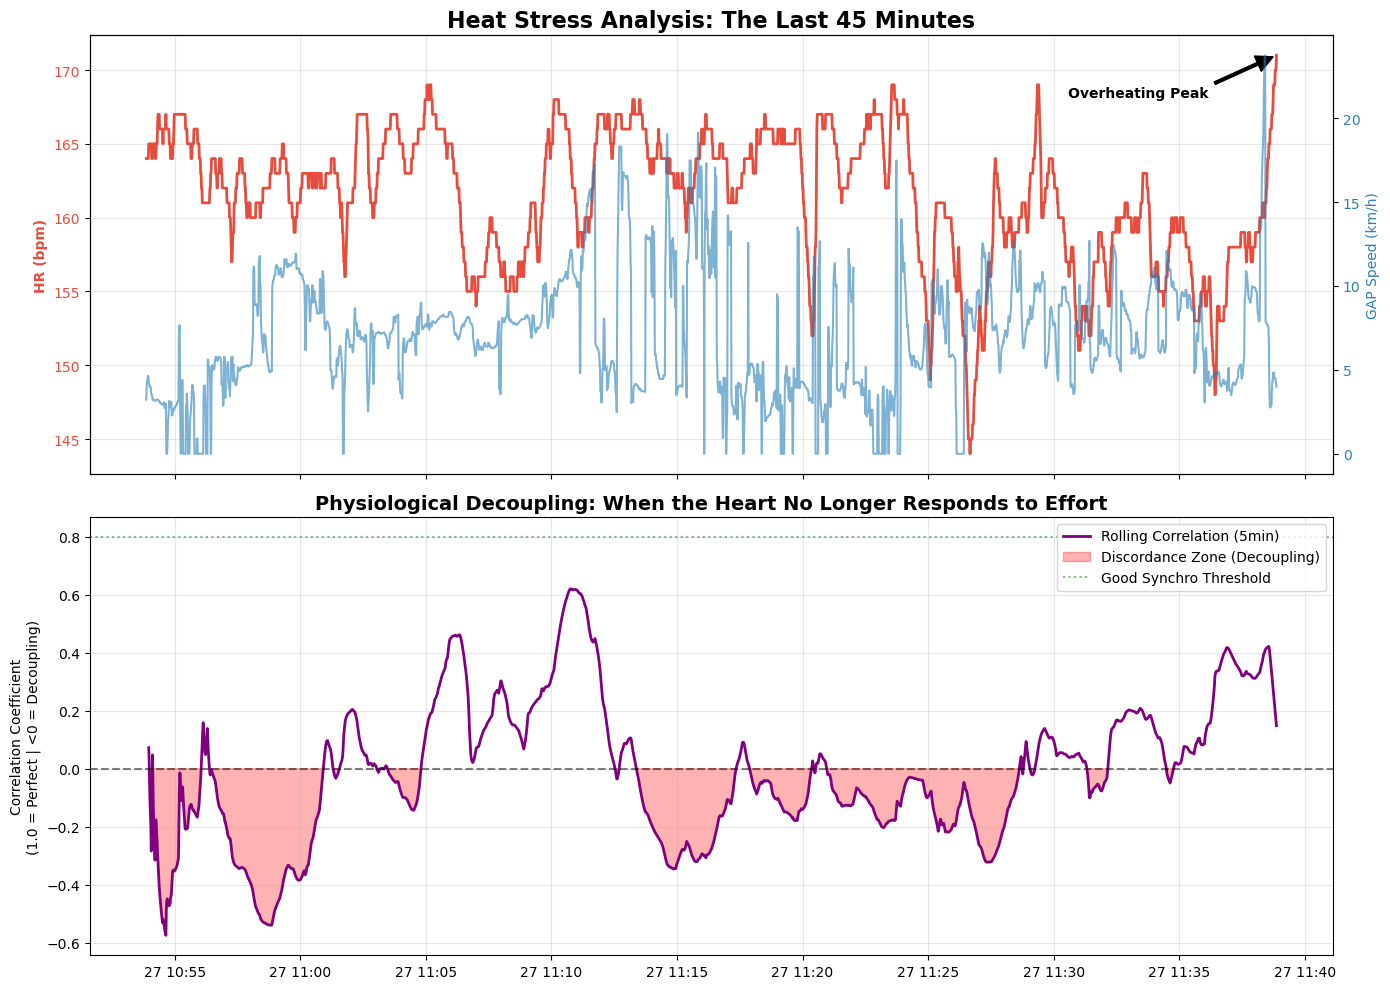

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- 1. PEAK IDENTIFICATION ---
# Find the exact moment of the 'hot flash' (Max HR)
time_peak = df['heart_rate'].idxmax()
max_hr = df['heart_rate'].max()

print(f"🔥 TARGET: HR Peak ({max_hr:.0f} bpm) reached at {time_peak}")

# --- 2. WINDOW ISOLATION (-45 minutes) ---
# Take the 45 minutes BEFORE the peak to observe the progressive degradation
start_window = time_peak - pd.Timedelta(minutes=45)
df_heat_buildup = df.loc[start_window:time_peak].copy()

# --- 3. THE MAGIC CALCULATION: ROLLING CORRELATION ---
# Calculate the correlation between GAP Speed and HR over a 5-minute rolling window.
# This shows "at every moment" how synchronized the two curves are.
df_heat_buildup['rolling_corr'] = df_heat_buildup['gap_speed'].rolling(window='5min').corr(df_heat_buildup['heart_rate'])


# --- 4. VISUALIZATION OF THE "DECOUPLING" ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# TOP GRAPH: RAW CURVES
ax1.set_title(f"Heat Stress Analysis: The Last 45 Minutes", fontsize=16, fontweight='bold')

# HR in Red
color_hr = '#e74c3c'
ax1.plot(df_heat_buildup.index, df_heat_buildup['heart_rate'], color=color_hr, label='Heart Rate', linewidth=2)
ax1.set_ylabel('HR (bpm)', color=color_hr, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_hr)
ax1.grid(True, alpha=0.3)

# GAP Speed in Blue (Right Axis)
ax1_speed = ax1.twinx()
color_speed = '#2980b9'
# Assuming 'gap_speed' is in m/s, convert to km/h
ax1_speed.plot(df_heat_buildup.index, df_heat_buildup['gap_speed']*3.6, color=color_speed, label='GAP Speed', alpha=0.6)
ax1_speed.set_ylabel('GAP Speed (km/h)', color=color_speed)
ax1_speed.tick_params(axis='y', labelcolor=color_speed)

# BOTTOM GRAPH: THE CORRELATION (THE PROOF)
# Correlation close to 1 = Everything is fine (Synchro)
# Dropping correlation = Problem (Decoupling)
ax2.plot(df_heat_buildup.index, df_heat_buildup['rolling_corr'], color='purple', linewidth=2, label='Rolling Correlation (5min)')

# Danger Zone (Correlation < 0)
# If the curve drops below zero, HR and Speed are moving in opposite directions!
ax2.fill_between(df_heat_buildup.index, df_heat_buildup['rolling_corr'], 0, where=(df_heat_buildup['rolling_corr'] < 0), color='red', alpha=0.3, label='Discordance Zone (Decoupling)')
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(0.8, color='green', linestyle=':', alpha=0.5, label='Good Synchro Threshold')

ax2.set_ylabel("Correlation Coefficient\n(1.0 = Perfect | <0 = Decoupling)", fontsize=10)
ax2.set_title("Physiological Decoupling: When the Heart No Longer Responds to Effort", fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# ANNOTATION 1: Point to the HR Peak
ax1.annotate('Overheating Peak', 
             xy=(time_peak, max_hr), 
             xytext=(-150, -30), 
             textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=10, fontweight='bold', color='black')

# ANNOTATION 2: Point to the worst decorrelation
min_corr_val = df_heat_buildup['rolling_corr'].min()
min_corr_time = df_heat_buildup['rolling_corr'].idxmin()

ax2.annotate('Worst Decoupling', 
             xy=(min_corr_time, min_corr_val), 
             xytext=(-150, 40), 
             textcoords='offset points',
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10),
             ha='center', 
             fontsize=10, fontweight='bold', color='red')

plt.xlabel("Time")
plt.tight_layout()
plt.show()

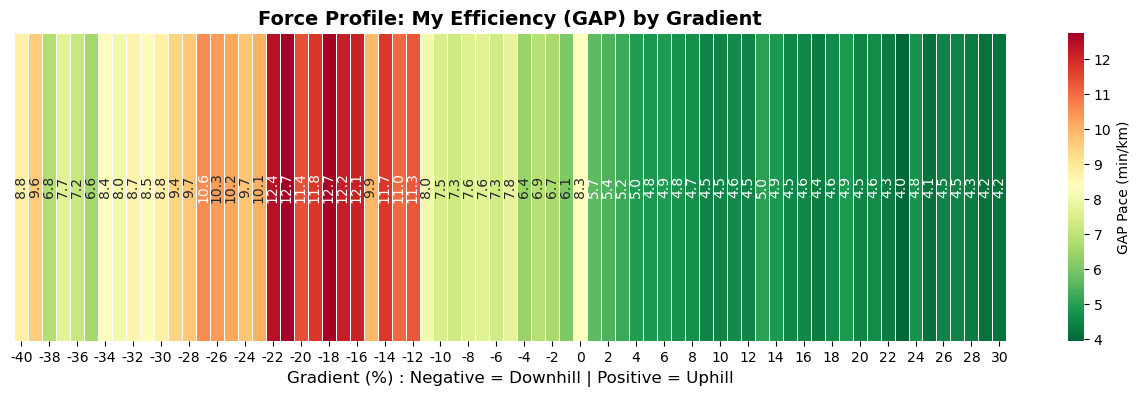

Correlation Coefficient (Gradient vs GAP Pace): -0.45


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. DATA PREPARATION ---
# Work on a copy
df_pace = df.copy()

# Conversion: Speed (m/s) -> GAP Pace (min/km)
# Assuming 'gap_speed' is in m/s, convert to km/h
df_pace['gap_kmh'] = df_pace['gap_speed'] * 3.6

# Calculate Pace: 60 / Speed
# Filter out outliers (pauses or GPS errors)
df_pace = df_pace[df_pace['gap_kmh'] > 3]
df_pace['gap_pace'] = 60 / df_pace['gap_kmh']

# Gradient Binning: Round to the nearest integer for grouping (e.g., 5.2% -> 5%)
df_pace['slope_bin'] = df_pace['slope_smooth'].round().astype(int)

# Filter to keep the useful zone (-40% to +40%)
df_viz = df_pace[(df_pace['slope_bin'] >= -40) & (df_pace['slope_bin'] <= 40)]

# --- 2. MATRIX CREATION (PIVOT TABLE) ---
# Group by slope and take the MEDIAN of your pace (more robust than the mean)
# Transpose (.T) to have the slopes on the horizontal axis
heatmap_data = df_viz.groupby('slope_bin')[['gap_pace']].median().T

# --- 3. VISUALIZATION (HEATMAP) ---
plt.figure(figsize=(16, 4))

# Create the Heatmap
# cmap='RdYlGn_r': Inverted Red-Yellow-Green Palette (_r)
# In running: Small number (e.g., 4:00/km) = Fast = Green. Large number = Slow = Red.
ax = sns.heatmap(
    heatmap_data,
    cmap='RdYlGn_r',
    annot=True,
    # Display the exact value (min/km) in the cell
    fmt=".1f",       # 1 decimal format
    cbar_kws={'label': 'GAP Pace (min/km)'},
    linewidths=0.5,  # Small space between cells
    square=False,
    annot_kws={"rotation": 90}
)

plt.title("Force Profile: My Efficiency (GAP) by Gradient", fontsize=14, fontweight='bold')
plt.xlabel("Gradient (%) : Negative = Downhill | Positive = Uphill", fontsize=12)
plt.yticks([]) # Hide the Y-axis which is not useful (single row)

plt.show()

# --- 4. STATISTICAL CORRELATION ---
# Calculate Pearson correlation coefficient between slope and pace
corr = df_viz[['slope_smooth', 'gap_pace']].corr().iloc[0, 1]
print(f"Correlation Coefficient (Gradient vs GAP Pace): {corr:.2f}")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
segments_config = [
    {'name': 'Montjoly', 'start_km': 0, 'end_km': 7.3},
    {'name': 'Stage', 'start_km': 23.5, 'end_km': 26.5},
    {'name': 'Col de la fenêtre', 'start_km': 28, 'end_km': 31.7},
    {'name': 'Tré-La-Tête', 'start_km': 36.7, 'end_km': 38.7},
    {'name': 'Plateau de Lacroix', 'start_km': 49.8, 'end_km': 51.7}
]

# 2. DATA CALCULATION
def calculate_cumulative_gain(series, threshold=0.5):
    diffs = series.diff()
    climbs = diffs[diffs > 0]
    return climbs.sum()

stats_list = []

for seg in segments_config:
    start_m = seg['start_km'] * 1000
    end_m = seg['end_km'] * 1000
    
    if start_m > df['distance'].max():
        continue

    # Find the nearest index for start and end points
    idx_start = (df['distance'] - start_m).abs().idxmin()
    idx_end = (df['distance'] - end_m).abs().idxmin()
    
    subset = df.loc[idx_start:idx_end].copy()
    
    if len(subset) > 10:
        # Smoothing and VAM calculation
        subset['alt_smooth'] = subset['enhanced_altitude'].rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')
        elevation_gain_cumulative = calculate_cumulative_gain(subset['alt_smooth'])
        duration_hours = (subset.index[-1] - subset.index[0]).total_seconds() / 3600
        
        if duration_hours > 0:
            vam = elevation_gain_cumulative / duration_hours
            
            stats_list.append({
                'Climb': seg['name'],
                'VAM (m/h)': vam,
                'Avg HR (bpm)': subset['heart_rate'].mean(),
                'Elev Gain (m)': elevation_gain_cumulative
            })

df_vam = pd.DataFrame(stats_list)

# --- 3. COMBINED VISUALIZATION (DUAL AXIS) ---

if not df_vam.empty:
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # --- A. BARS (VAM) on the LEFT axis ---
    sns.barplot(
        data=df_vam,
        x='Climb',
        y='VAM (m/h)',
        hue='VAM (m/h)',
        palette='Blues',
        dodge=False,
        ax=ax1,
        alpha=0.6 # Transparency to let the red line stand out
    )
    
    # Remove automatic bar legend
    if ax1.get_legend():
        ax1.legend_.remove()

    ax1.set_ylabel("Vertical Ascent Rate (m/h)", color='#1f77b4', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.set_title('Climbing Speed Analysis (VAM & Heart Rate)', fontsize=16, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_xlabel('Climb Segment', fontsize=12)

    # --- B. LINE (HR) on the RIGHT axis ---
    ax2 = ax1.twinx() # Create a twin axis sharing the same X-axis
    
    sns.lineplot(
        data=df_vam,
        x='Climb',
        y='Avg HR (bpm)',
        color='red',
        marker='o',      # Round markers
        markersize=10,   # Large markers
        linewidth=3,     # Thick line
        ax=ax2,
        label='Average HR'
    )

    ax2.set_ylabel("Heart Rate (bpm)", color='red', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Adjust HR scale for better visualization
    min_hr = df_vam['Avg HR (bpm)'].min() - 10
    max_hr = df_vam['Avg HR (bpm)'].max() + 10
    ax2.set_ylim(min_hr, max_hr)

    # --- C. ANNOTATIONS ---
    # VAM values on the bars
    for p in ax1.patches:
        height = p.get_height()
        if np.isfinite(height) and height > 0:
            ax1.annotate(f'{int(height)} m/h', 
                         (p.get_x() + p.get_width() / 2., height/2), # Center of the bar
                         ha='center', va='center', color='black', fontweight='bold')

    # HR values above the red points
    for i, row in df_vam.iterrows():
        ax2.annotate(f"{int(row['Avg HR (bpm)'])} bpm", 
                     (i, row['Avg HR (bpm)']), 
                     textcoords="offset points", 
                     xytext=(20,15), 
                     ha='center', color='red', fontweight='bold')

    plt.show()